In [1]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add, Multiply
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
print "import keras"

import numpy as np
# from tqdm import tqdm
import time
import pickle
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d

print "import sklearn"

np.random.seed(42)


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


import tensorflow
import keras

Using TensorFlow backend.



import matplotlib
import sklearn


In [2]:
def Minv(cols,ptetaphi=False,nopy2=False):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def get_dphi(px1,py1,px2,py2):
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return dphi

def get_rotated_pxpy(px1,py1,px2,py2):
    """
    rotates two leptons such that phi2 = 0
    """
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    px1p = pt1*np.cos(phi1-phi2)
    py1p = pt1*np.sin(phi1-phi2)
    px2p = pt2*np.cos(phi2-phi2)
    return px1p,py1p,px2p,np.zeros(len(pt2))
    
def cartesian_zerophi2(coords,ptetaphi=False):
    """
    returns 8-1=7 columns rotating leptons such that phi2 is 0 (and removing it)
    if `ptetaphi` is True, then return eptetaphi instead of epxpypz
    """
    lepcoords_cyl = cartesian_to_ptetaphi(coords)
    phi1 = lepcoords_cyl[:,3]
    phi2 = lepcoords_cyl[:,7]
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi
    lepcoords_cyl[:,3] = dphi
    lepcoords_cyl[:,7] = 0.
    if ptetaphi:
        return np.delete(lepcoords_cyl, [7], axis=1)
    else:
        return np.delete(ptetaphi_to_cartesian(lepcoords_cyl), [6], axis=1)

In [30]:
def invmass_from_8cartesian(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]+x[:,6:7])**2-
                (x[:,3:4]+x[:,7:8])**2
                )
    return invmass

def invmass_from_8cartesian_nopy2(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]         )**2-
                (x[:,3:4]+x[:,6:7])**2
                )
    return invmass

def get_first_N(x,N):
    return x[:,0:N]

def add_invmass_from_8cartesian(x):
    return K.concatenate([x,invmass_from_8cartesian(x)])


def fix_outputs(x):
    """
    Take nominal delphes format of 19 columns and fix some columns
    """
    return K.concatenate([
        # x[:,0:21],
        x[:,0:7], # epxpypz for lep1,lep2 -1 for no py2
        x[:,7:8], # nvtx
        K.sign(x[:,8:10]), # q1 q2
        x[:,10:12], # iso1 iso2
        x[:,12:14], # met, metphi
        x[:,14:19], # jet pts
        ])

def custom_loss(c):
    def loss_func(y_true, y_pred_mll):
        y_true = y_true[:,0]
        y_pred = y_pred_mll[:,0]
        mll_pred = y_pred_mll[:,1]
        
#         89.592094 7.731601
        mll_loss = K.mean((mll_pred - 89.6)**2)
        mll_std_loss = (K.std(mll_pred)-7.73)**2

        return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_std_loss
    return loss_func

In [61]:
def make_plots(preds,reals,title="",fname="",show_pred=True,wspace=0.1,hspace=0.3,tightlayout=True):
    nrows, ncols = 5,5
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
#     fig, axs = plt.subplots(nrows,ncols,figsize=(12,10))
#     fig.subplots_adjust(wspace=0.1,hspace=0.3)
    fig.subplots_adjust(wspace=wspace,hspace=hspace)


    info = [
        ["mll",(60,120,50)],
        ["lep1_e",(0,250,50)],
        ["lep1_px",(-100,100,50)],
        ["lep1_py",(-100,100,50)],
        ["lep1_pz",(-200,200,50)],
        ["lep2_e",(0,250,50)],
        ["lep2_px",(-100,100,50)],
        ["lep2_pz",(-200,200,50)],
        ["dphi",(-4,4,50)],
        ["nvtxs",(0,50,350)],
        ["met",(0,150,50)],
        ["metphi",(-6,6,50)],
        ["lep1_charge",(-7,7,30)],
        ["lep2_charge",(-7,7,30)],
        ["lep1_iso",(0,2.0,30)],
        ["lep2_iso",(0,2.0,30)],
        ["jet_pt1",(0,100,50)],
        ["jet_pt2",(0,100,50)],
        ["jet_pt3",(0,100,50)],
        ["jet_pt4",(0,100,50)],
        ["jet_pt5",(0,100,50)],
        ["njets",(0,7,7)],

    ]
    for axx in axs:
        for ax in axx:
            ax.get_yaxis().set_visible(False)
    for ic,(cname,crange) in enumerate(info):
        if cname == "mll":
            real = reals["mll"]
            pred = Minv(preds,ptetaphi=False,nopy2=True)
        elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
        elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
        elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
        elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
        elif cname == "lep1_px": 
            real = reals[cname]
            pred = preds[:,1]
        elif cname == "lep1_py":
            real = reals[cname]
            pred = preds[:,2]
        elif cname == "lep2_px":
            real = reals[cname]
            pred = preds[:,5]
        elif cname == "dphi":
            real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], np.zeros(len(reals)))
            pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
        elif cname == "nvtxs": real, pred = reals[cname], np.round(preds[:,7])
        elif cname == "lep1_charge": real, pred = reals[cname], preds[:,8]
        elif cname == "lep2_charge": real, pred = reals[cname], preds[:,9]
        elif cname == "lep1_iso": real, pred = reals[cname], preds[:,10]
        elif cname == "lep2_iso": real, pred = reals[cname], preds[:,11]
        elif cname == "met": real, pred = reals[cname], preds[:,12]
        elif cname == "metphi": real, pred = reals[cname], preds[:,13]
        elif cname == "jet_pt1": real, pred = reals[cname], preds[:,14]
        elif cname == "jet_pt2": real, pred = reals[cname], preds[:,15]
        elif cname == "jet_pt3": real, pred = reals[cname], preds[:,16]
        elif cname == "jet_pt4": real, pred = reals[cname], preds[:,17]
        elif cname == "jet_pt5": real, pred = reals[cname], preds[:,18]
        elif cname == "njets":
            real = \
                1*(reals["jet_pt1"] > 10) + \
                1*(reals["jet_pt2"] > 10) + \
                1*(reals["jet_pt3"] > 10) + \
                1*(reals["jet_pt4"] > 10) + \
                1*(reals["jet_pt5"] > 10)
            pred = \
                1*(preds[:,14] > 10) + \
                1*(preds[:,15] > 10) + \
                1*(preds[:,16] > 10) + \
                1*(preds[:,17] > 10) + \
                1*(preds[:,18] > 10)
        idx = ic // ncols, ic % ncols
        bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        if show_pred:
            bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        axs[idx].set_xlabel("{}".format(cname))
        axs[idx].get_yaxis().set_visible(False)
    #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right')
    _ = axs[0,0].set_title(title)
    if tightlayout:
        plt.tight_layout()
    if fname:
        fig.savefig(fname)


In [62]:
def get_recview(data, dtype="<f4"):
    """
    for example, can give it a matrix of values predicted by generator
    and this gives a view of the same matrix with dtypes (for easier column selection)
    if weird results, like 2 columns per field, use dtype="<f8"
    """
    cnames = [
    "lep1_e",
    "lep1_px",
    "lep1_py",
    "lep1_pz",
    "lep2_e",
    "lep2_px",
    "lep2_pz",
    "nvtxs",
    "lep1_charge",
    "lep2_charge",
    "lep1_iso",
    "lep2_iso",
    "met",
    "metphi",
    "jet_pt1",
    "jet_pt2",
    "jet_pt3",
    "jet_pt4",
    "jet_pt5",
    ]
    cnames = [(cn,dtype) for cn in cnames]
    return data.view(dtype=cnames)

## GAN class
Instantiate the GAN class, then add methods piece by piece (by making a "new" class inheriting from the original).
I did this so that all these long functions could go into different cells, which makes it easier to navigate/read.

In [142]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.tag = kwargs["tag"]
        self.input_file = str(kwargs["input_file"])
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.noise_type = int(kwargs["noise_type"])
        self.ntest_samples = int(kwargs["ntest_samples"])
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_models = int(kwargs["nepochs_dump_models"])
        self.nepochs_dump_plots = int(kwargs["nepochs_dump_plots"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_concatenate_disc = kwargs["do_concatenate_disc"]
        self.do_concatenate_gen = kwargs["do_concatenate_gen"]
        self.do_batch_normalization_disc = kwargs["do_batch_normalization_disc"]
        self.do_batch_normalization_gen = kwargs["do_batch_normalization_gen"]
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.do_tanh_gen = kwargs["do_tanh_gen"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.use_ptetaphi_additionally = kwargs["use_ptetaphi_additionally"]
        self.optimizer_gen = kwargs["optimizer_gen"]
        self.optimizer_disc = kwargs["optimizer_disc"]
        self.depth_disc = kwargs["depth_disc"]
        self.width_disc = kwargs["width_disc"]
        self.depth_gen = kwargs["depth_gen"]
        self.width_gen = kwargs["width_gen"]
        self.beefy_generator = kwargs["beefy_generator"]
        self.beefy_discriminator = kwargs["beefy_discriminator"]
        self.super_beefy_generator = kwargs["super_beefy_generator"]
        self.super_beefy_discriminator = kwargs["super_beefy_discriminator"]
        self.add_invmass_disc = kwargs["add_invmass_disc"]
        self.fix_delphes_outputs = kwargs["fix_delphes_outputs"]
        self.use_delphes = kwargs["use_delphes"]
        self.use_mll_loss = kwargs["use_mll_loss"]
        self.loss_mll_weight = kwargs["loss_mll_weight"]
        self.do_skip_connection = kwargs["do_skip_connection"]
        self.terminate_early = kwargs["terminate_early"]
        self.dropout_discriminator = kwargs["dropout_discriminator"]
        self.frac_true = kwargs["frac_true"]
        if self.use_ptetaphi_additionally: self.output_shape = (self.output_shape[0]+8,)

        os.system("mkdir -p progress/{}/".format(self.tag))
        os.system("cp gan.py progress/{}/".format(self.tag))

        self.scaler_type = kwargs["scaler_type"]
        self.scaler = None
        if self.scaler_type.lower() == "minmax":
            self.scaler = MinMaxScaler(feature_range=(-1.,1.))
        elif self.scaler_type.lower() == "robust":
            self.scaler = RobustScaler()
        elif self.scaler_type.lower() == "standard":
            self.scaler = StandardScaler()

        self.data = None
        self.data_ref = None
        self.d_epochinfo = {}
        self.X_train = None

        # optimizer = Adam(0.0002, 0.5)
        optimizer_d = self.optimizer_disc
        # optimizer_d = "sgd"
        optimizer_g = self.optimizer_gen
        # optimizer_g = "adam"

        # Build and compile the discriminator
        if self.use_mll_loss:
            loss = custom_loss(c=self.loss_mll_weight)
        else:
            loss = "binary_crossentropy"
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=loss,
            optimizer=optimizer_d,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=loss, optimizer=optimizer_g)

        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=loss, optimizer=optimizer_g)


In [143]:
class GAN(GAN):
    
    def build_generator(self):

        inputs = Input(shape=self.noise_shape)

        ## Head
        x = Dense(64)(inputs)
        if self.do_batch_normalization_gen:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if self.do_concatenate_gen:
            x = Lambda(lambda x: K.concatenate([x*x,x]))(x)
            x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_gen > 0 and self.width_gen > 0:
            for level in xrange(0,self.depth_gen):
                x = Dense(width_gen/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_generator:
            for size in [128,256,512,256,128]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
        elif self.super_beefy_generator:
            for size in [128,128,256,256,512,1024,512,256,256,256]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128,128,128,64,32]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
 
    
        ## Tail
#         tomul = Dense(self.output_shape[0])(x)
        x = Dense(self.output_shape[0])(x)
        
        
#         kfact = 0.01
#         x = Dense(self.output_shape[0], 
#                 kernel_regularizer=keras.regularizers.l2(kfact),
#                 activity_regularizer=keras.regularizers.l1(kfact),
#                 kernel_constraint=keras.constraints.max_norm(0.1),
#                 bias_constraint=keras.constraints.max_norm(0.1),
#                 )(x)
        
#         kfact = -0.00001
#         x = Dense(self.output_shape[0], 
#                 kernel_regularizer=keras.regularizers.l2(kfact),
#                 activity_regularizer=keras.regularizers.l1(kfact),
#                 kernel_constraint=keras.constraints.max_norm(0.1),
#                 bias_constraint=keras.constraints.max_norm(0.1),
#                 )(x)
        
#         if False:
        if self.do_skip_connection:
            # get the non-noise part of the input, and add it to the tail
            # note the default argument because lambda is late binding
            y = Lambda(lambda y,w=self.output_shape[0]: get_first_N(y,w))(inputs)
#             y = keras.layers.GaussianNoise(5.0)(y)
#             fsmear = 0.01 # 1% width for gaussian smearing
#             fsmear = 0.15
#             y = keras.layers.GaussianDropout(fsmear**2/(1+fsmear**2))(y)
#             print y
            x = Add()([x,y])
# output = tomul*input + x
#             x = Multiply()([tomul,y])
#             x = Add()([x,y])
#             x = Multiply()([x,y])
#             x = Dense(self.output_shape[0])(x)
#             print x
            
        if self.do_tanh_gen:
            x = Activation("tanh")(x)
        elif self.fix_delphes_outputs:
            x = Lambda(fix_outputs,
                input_shape=self.output_shape,
                output_shape=self.output_shape
                )(x)
            
#         model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        model = Model(inputs=inputs, outputs=[x])
        
        print "Generator params: {}".format(model.count_params())
#         model.summary()
        
        return model

In [144]:
class GAN(GAN):
    
    def build_discriminator(self):

        inputs = Input(self.output_shape)
        mll = Lambda(invmass_from_8cartesian_nopy2)(inputs)
        x = Dense(128)(inputs)
        if self.do_batch_normalization_disc:
            x = BatchNormalization()(x)
        if self.do_concatenate_disc:
            x = Lambda(lambda x: K.concatenate([x*x,x]))(x)
            x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_disc > 0 and self.width_disc > 0:
            for level in xrange(0,self.depth_disc):
                x = Dense(self.width_disc/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_discriminator:
            for size in [256,512,256,128,128,64,32,16,8]:
                x = Dense(size)(x)
                if self.dropout_discriminator:
                    x = Dropout(0.1)(x)
                x = LeakyReLU(alpha=0.2)(x)

        elif self.super_beefy_discriminator:
            for size in [512,256,256,128,128,128,64,64,32,32,16,16,8]:
                x = Dense(size)(x)
                if self.dropout_discriminator:
                    x = Dropout(0.1)(x)
                x = LeakyReLU(alpha=0.2)(x)

        else:
            for size in [128]*5 + [64,32,16,8]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)

        ## Tail
        out = Dense(1,activation='sigmoid')(x)
        
        if self.use_mll_loss:
            model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        else:
            model = Model(inputs=inputs, outputs=out)
#         print model.output_shape
#         model.summary()
        print "Discriminator params: {}".format(model.count_params())
        
        return model
        


In [145]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        if self.use_delphes:
            self.data = np.load(self.input_file)
        else:
            self.data = np.load(self.input_file)
            
        # make sure we drop low mass resonances
        self.data = self.data[self.data["genmll"] > 50.]

In [146]:
class GAN(GAN):

    def get_noise(self, amount=1024, max_true_samples=-1, max_true_samples_frac=-1):
        """
        `amount` specifies number of noise vectors
        `max_true_samples` applies only to truth conditioned noise type
            if > 0, then the true samples are sampled from the first 
            `max_true_samples` of real events (by default, all are allowed)
        `max_true_samples_frac` same desc as `max_true_samples`, but specified
            instead as fraction of `amount`
        """
        # nominal
        if self.noise_type == 1:
            noise_half = np.random.normal(0, 1, (amount//2, self.noise_shape[0]))
            noise_full = np.random.normal(0, 1, (amount, self.noise_shape[0]))

        elif self.noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
            ngaus = self.noise_shape[0] // 2
            nflat = (self.noise_shape[0] - ngaus) // 2
            nexpo = self.noise_shape[0] - nflat - ngaus
            noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
            noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
            noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
            noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
            noise_half = noise[:amount//2]
            noise_full = noise[-amount:]
            
        elif self.noise_type == 3: # truth conditioned
            
            npurenoise = self.noise_shape[0]-self.X_train.shape[1]
            first_idx = 0
            last_idx = self.X_train.shape[0] 
            if max_true_samples > 0:
                last_idx = max_true_samples
            if max_true_samples_frac > 0:
                nmax = int(max_true_samples_frac*amount)
                first_idx = np.random.randint(0, self.X_train.shape[0]-nmax-1)
                last_idx = first_idx + nmax
            noise_half = np.c_[ 
                    self.X_train[np.random.randint(first_idx, last_idx, amount//2)], 
                    np.random.normal(0, 1, (amount//2,npurenoise))
                    ]
            noise_full = np.c_[ 
                    self.X_train[np.random.randint(first_idx, last_idx, amount)], 
                    np.random.normal(0, 1, (amount,npurenoise))
                    ]
            
#             npurenoise = self.noise_shape[0]-self.X_train.shape[1]
#             ngaus = npurenoise // 2
#             nflat = (npurenoise - ngaus) // 2
#             nexpo = npurenoise - nflat - ngaus
#             noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
#             noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
#             noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
#             truenoise = self.X_train[np.random.randint(0, self.X_train.shape[0], amount//2+amount)]
#             noise = np.c_[ truenoise,noise_gaus,noise_flat,noise_expo ]
#             noise_half = noise[:amount//2]
#             noise_full = noise[-amount:]

        return noise_half, noise_full



In [147]:
class GAN(GAN):
            
    def train(self):

        self.load_data()
        
        
        if self.use_delphes:
            lepcoords = np.c_[
                self.data["lep1_e"],
                self.data["lep1_px"],
                self.data["lep1_py"],
                self.data["lep1_pz"],
                self.data["lep2_e"],
                self.data["lep2_px"],
#                 self.data["lep2_py"],
                self.data["lep2_pz"],
            ]
#             lepcoords_dphi = cartesian_zerophi2(lepcoords)
            
            nvtx_smeared = np.round(np.random.normal(self.data["nvtxs"],0.5))
            self.X_train = np.c_[
#                 lepcoords_dphi, # 7 columns
                lepcoords, # 7 columns
                nvtx_smeared, # 1 column
                self.data["lep1_charge"], self.data["lep2_charge"],
                self.data["lep1_iso"], self.data["lep2_iso"],
                self.data["met"], self.data["metphi"],
                self.data["jet_pt1"],
                self.data["jet_pt2"],
                self.data["jet_pt3"],
                self.data["jet_pt4"],
                self.data["jet_pt5"],
            ].astype(np.float32)
        else:
            self.X_train = self.data[:,range(1,1+8)]
            if self.use_ptetaphi_additionally:
                self.X_train = np.c_[self.X_train, cartesian_to_ptetaphi(self.X_train)]

        # # NOTE. StandardScaler should be fit on training set
        # # and applied the same to train and test, otherwise we
        # # introduce a bias
        if self.scaler:
            self.scaler.fit(self.X_train)
            self.X_train = self.scaler.transform(self.X_train).astype(np.float32)
            pickle.dump(self.scaler, open("progress/{}/scaler.pkl".format(self.tag),'w'))

        # make an alias to save typing
        X_train = self.X_train
        
        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        for epoch in range(self.nepochs_max):

            if self.terminate_early:
                if n_loss_same_gen > 1000 or n_loss_same_disc > 1000:
                    print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                    break

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            noise_half, noise_full = self.get_noise(self.batch_size, max_true_samples_frac=self.frac_true)
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise_half)

            # Train the discriminator
            ones = np.ones((half_batch, 1))
            zeros = np.zeros((half_batch, 1))

            if self.do_soft_labels:
                ones *= 0.9

            if self.do_noisy_labels:
                frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                if frac > 0.005:
                    ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                    zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

            d_loss_real = self.discriminator.train_on_batch(imgs, ones)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, zeros)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * self.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]

            # Plot the progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            sys.stdout.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}]".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1]))

            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
            
                _, noise_test = self.get_noise(self.ntest_samples,  max_true_samples_frac=self.frac_true)
            
                sys.stdout.write("\n") # break up the stream of text

                gen_imgs = self.generator.predict(noise_test)

                if self.scaler:
                    gen_imgs = self.scaler.inverse_transform(gen_imgs)

                masses = Minv(gen_imgs,nopy2=True)
                masses = masses[np.isfinite(masses)]
                old_info = masses.mean(), masses.std()

                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                    self.d_epochinfo["mass_mu"] = []
                    self.d_epochinfo["mass_sig"] = []
                    self.d_epochinfo["time"] = []
                    self.d_epochinfo["args"] = self.args
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)
                    self.d_epochinfo["mass_mu"].append(masses.mean())
                    self.d_epochinfo["mass_sig"].append(masses.std())
                    self.d_epochinfo["time"].append(time.time())

                pickle.dump(self.d_epochinfo, open("progress/{}/history.pkl".format(self.tag),'w'))

            if epoch % self.nepochs_dump_plots == 0 and epoch > 0:
                _, noise = self.get_noise(self.ntest_samples,  max_true_samples_frac=self.frac_true)
                preds = gan.generator.predict(noise)
                reals = self.data[:15000]
                _ = make_plots(preds,reals,title="{}: epoch {}".format(self.tag,epoch),
                               fname="progress/{}/plots_{:06d}.png".format(self.tag,epoch))
            
            if epoch % self.nepochs_dump_models == 0 and epoch > 0:
                self.discriminator.save("progress/{}/disc_{}.weights".format(self.tag,epoch))
                self.generator.save("progress/{}/gen_{}.weights".format(self.tag,epoch))

## Set parameters and instantiate
Parameters, plots, epoch metrics, get saved to folder `progress/<tag>`.

In [148]:
# defaults
params = {
        "input_file": "data_xyz.npy",
        "output_size": 8,
        "noise_size": 8,
        "noise_type": 1,
        "ntest_samples": 10000,
        "nepochs_dump_pred_metrics": 250,
        "nepochs_dump_plots": 500,
        "nepochs_dump_models": 5000,
        "nepochs_max": 25001,
        "batch_size": 200,
        "do_concatenate_disc": False,
        "do_concatenate_gen": False,
        "do_batch_normalization_disc": False,
        "do_batch_normalization_gen": False,
        "do_soft_labels": False,
        "do_noisy_labels": False,
        "do_tanh_gen": False,
        "nepochs_decay_noisy_labels": 3000,
        "use_ptetaphi_additionally": False,
        "scaler_type": "",
        "optimizer_disc": "adadelta",
        "optimizer_gen": "adadelta",
        "beefy_generator": False,
        "beefy_discriminator": False,
        "super_beefy_generator": False,
        "super_beefy_discriminator": False,
        "dropout_discriminator": False,
        "depth_gen": 0,
        "width_gen": 0,
        "depth_disc": 0,
        "width_disc": 0,
        "add_invmass_disc": False,
        "fix_delphes_outputs": False,
        "use_delphes": False,
        "use_mll_loss": False,
        "loss_mll_weight": 0.0001,
        "do_skip_connection": False,
        "terminate_early": True,
        "frac_true": -1,
        }

# for delphes:
params.update({
    "use_delphes": True,
    "fix_delphes_outputs": True,
    "do_soft_labels": True,
    "do_noisy_labels": True,
    "nepochs_decay_noisy_labels": 2000,
    "input_file": "/home/users/namin/2017/gan/total_Zmumu_13TeV_PU20_v2.npa",
#     "input_file": "/home/users/namin/2017/gan/total_Zmumu_13TeV_PU20.npa",
    "output_size": 19,
})
params.update({
    "noise_type": 3,
    "noise_size": 19+12, # 19 for the true events and 8 more for noise
#     "noise_size": 19+16, # 19 for the true events and 8 more for noise
    
#     "do_concatenate_disc": True,
    
    "use_mll_loss": True,
    "loss_mll_weight": 0.001,
    
    "nepochs_max": 40001,
    "batch_size": 512,
    "do_skip_connection": True,
    "terminate_early": False,
    "nepochs_dump_models": 9999999, # can't dump models? FIXME
    
    "beefy_generator": True,
    "beefy_discriminator": False,
    "super_beefy_generator": False,
    "super_beefy_discriminator": True,
    
    "dropout_discriminator": False,
    "do_soft_labels": False,
    "do_noisy_labels": False,
    
#     "optimizer_disc": "adam",
#     "optimizer_gen": "adam",
#     "optimizer_disc": "rmsprop",
#     "optimizer_gen": "rmsprop",
#     "frac_true": 0.01,
})
# params.update({
#     "do_skip_connection": False,
#     "noise_type": 1,
#     "noise_size": 16,
# })
print params
    
# change tag for provenance
# params["tag"] = "v1_512_bgbd_nomll"
# params["tag"] = "v1_512_skipconn_bgbd_nomll"
# params["tag"] = "v1_512_skipconn_bgbd_mll0.001"
# params["tag"] = "v1_512_skipconn_bgbd_nomll_try2" # actually fix beefy discriminator, before it was not beefy
# params["tag"] = "v1_512_skipconn_bgbd_mll0p001_try2"
# params["tag"] = "v1_512_skipconn_bgbd_mll0p0001_dropdisc"
# params["tag"] = "v1_512_skipconn_bgbd_mll0p0001_adam"
# params["tag"] = "v1_1024_skipconn_bgbd_mll0p0001"
# params["tag"] = "v2_512_skipconn_bgbd_mll0p0001_nosoft"
# params["tag"] = "v1_sc_sbgd_c0p001_gstd_f0p01"
params["tag"] = "v1_sc_bgsbd_c0p001_gstd"
# params["tag"] = "v1_sbgd_c0p001_gstd"

gan = GAN(**params)

# params1 = params.copy()
# params2 = params.copy()
# params2.update({"use_mll_loss":False})
# gan1 = GAN(**params1)
# gan2 = GAN(**params2)

{'width_disc': 0, 'ntest_samples': 10000, 'optimizer_disc': 'adadelta', 'noise_type': 3, 'output_size': 19, 'terminate_early': False, 'do_batch_normalization_disc': False, 'use_delphes': True, 'nepochs_dump_plots': 500, 'use_ptetaphi_additionally': False, 'do_noisy_labels': False, 'nepochs_dump_pred_metrics': 250, 'super_beefy_generator': False, 'do_batch_normalization_gen': False, 'add_invmass_disc': False, 'super_beefy_discriminator': True, 'width_gen': 0, 'fix_delphes_outputs': True, 'do_skip_connection': True, 'nepochs_dump_models': 9999999, 'input_file': '/home/users/namin/2017/gan/total_Zmumu_13TeV_PU20_v2.npa', 'dropout_discriminator': False, 'scaler_type': '', 'batch_size': 512, 'do_concatenate_disc': False, 'do_soft_labels': False, 'depth_gen': 0, 'noise_size': 31, 'frac_true': -1, 'loss_mll_weight': 0.001, 'nepochs_max': 40001, 'beefy_discriminator': False, 'depth_disc': 0, 'do_tanh_gen': False, 'do_concatenate_gen': False, 'use_mll_loss': True, 'beefy_generator': True, 'nepo

## Train

250 [D loss: 0.992351174355, acc.: 0.00%] [G loss: 0.766484797001] [mll=-1.000+--1.000]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


500 [D loss: 0.791195333004, acc.: 0.00%] [G loss: 0.861085534096] [mll=89.619+-11.180]
750 [D loss: 0.758822321892, acc.: 0.00%] [G loss: 1.00809657574] [mll=88.844+-10.113]]
1000 [D loss: 0.958190381527, acc.: 0.00%] [G loss: 0.797752857208] [mll=87.997+-8.743]
1250 [D loss: 0.823296308517, acc.: 0.00%] [G loss: 0.755668222904] [mll=89.929+-8.343]
1476 [D loss: 0.789678096771, acc.: 0.00%] [G loss: 0.784238398075] [mll=88.926+-8.940]

KeyboardInterrupt: 

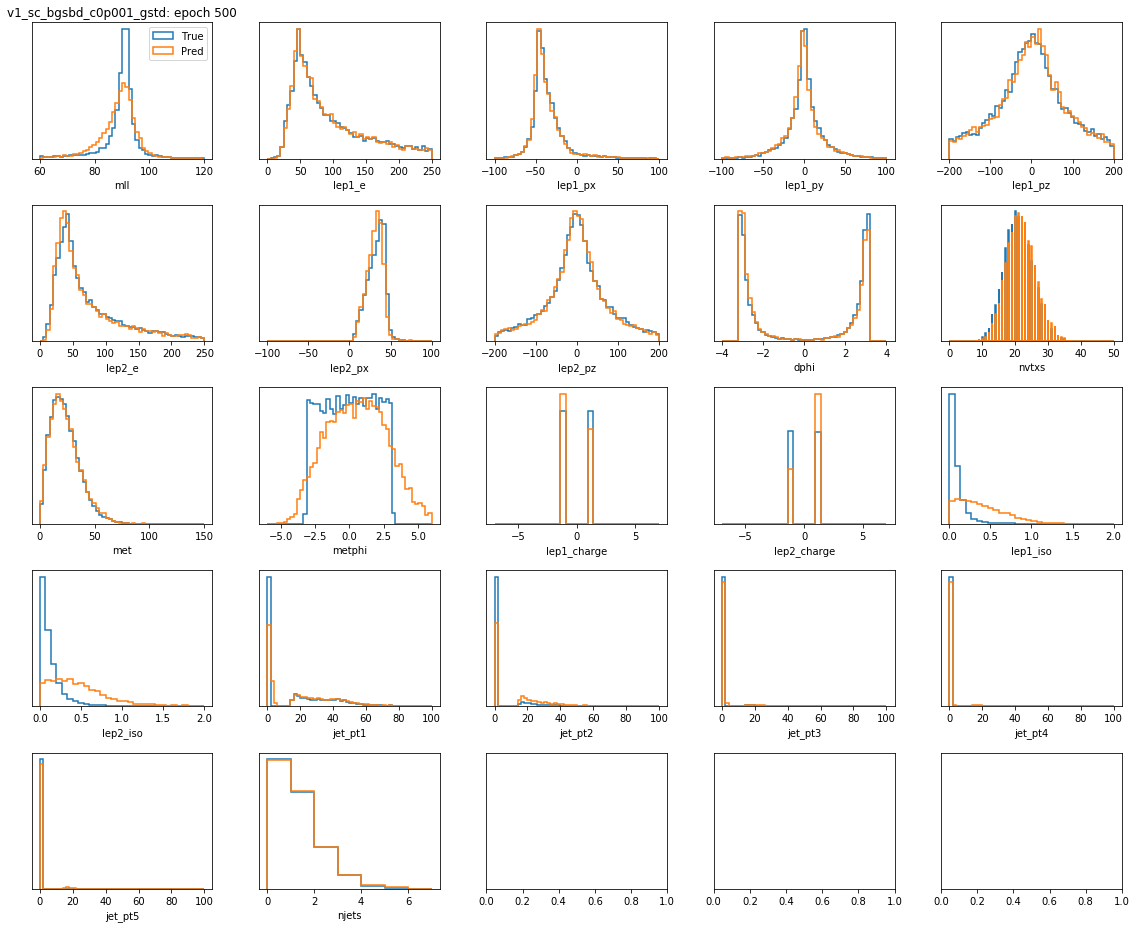

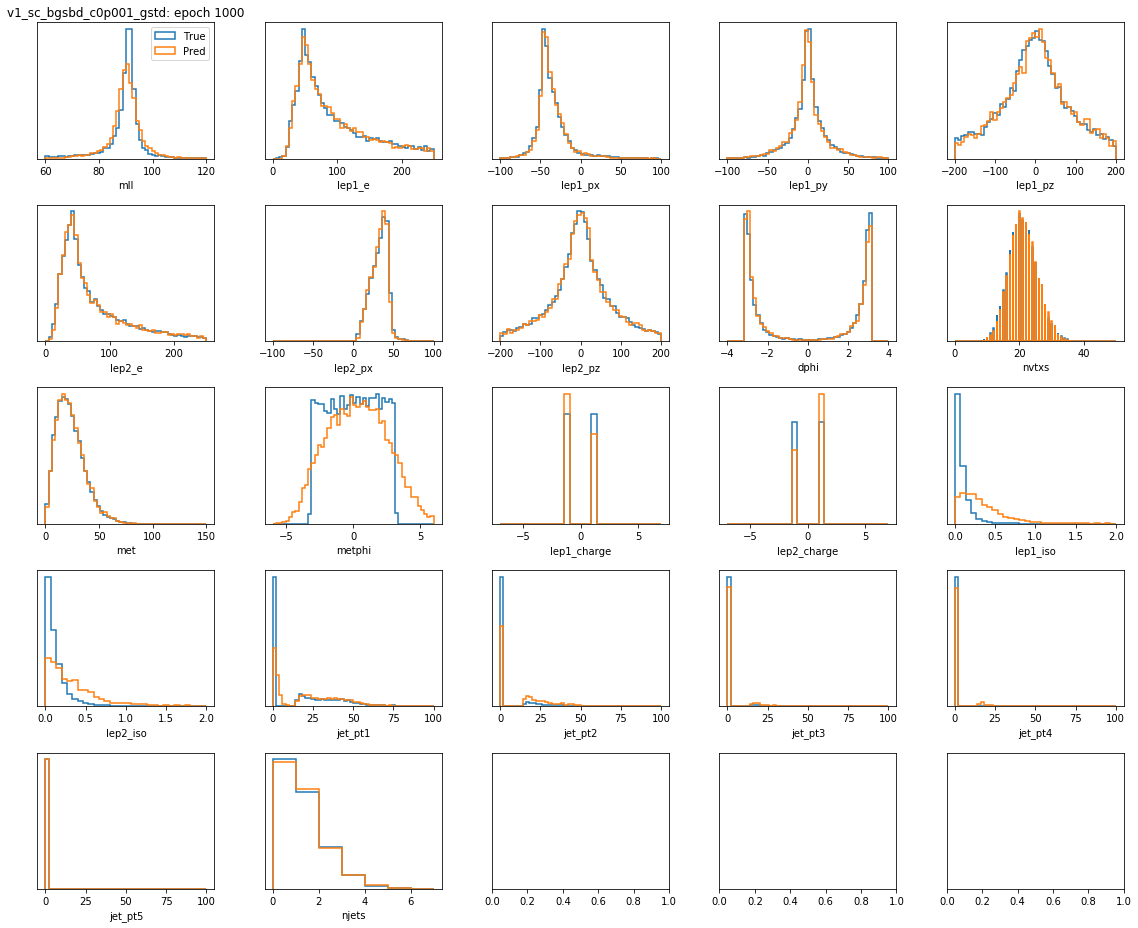

In [149]:
gan.train()

## Plot metrics vs epoch

In [150]:
# print gan1
print np.array(gan.d_epochinfo["epoch"])

[ 500  750 1000 1250]


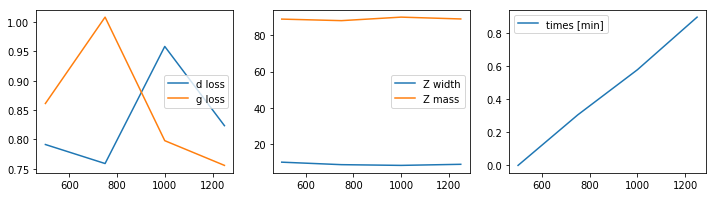

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3))
# plot losses
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["d_loss"],label="d loss")
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["g_loss"],label="g loss")
ax1.legend()
# plot masses
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_sig"],label="Z width")
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_mu"], label="Z mass")
ax2.legend()
# plot times
ax3.plot(gan.d_epochinfo["epoch"],1./60*(np.array(gan.d_epochinfo["time"])-gan.d_epochinfo["time"][0]), label="times [min]")
ax3.legend()

## Plot predictions and real events
Get the noise from the gan object, feed it into the generator, then also take true events (`data`)

20000/20000 [==============================] - 1s 65us/step


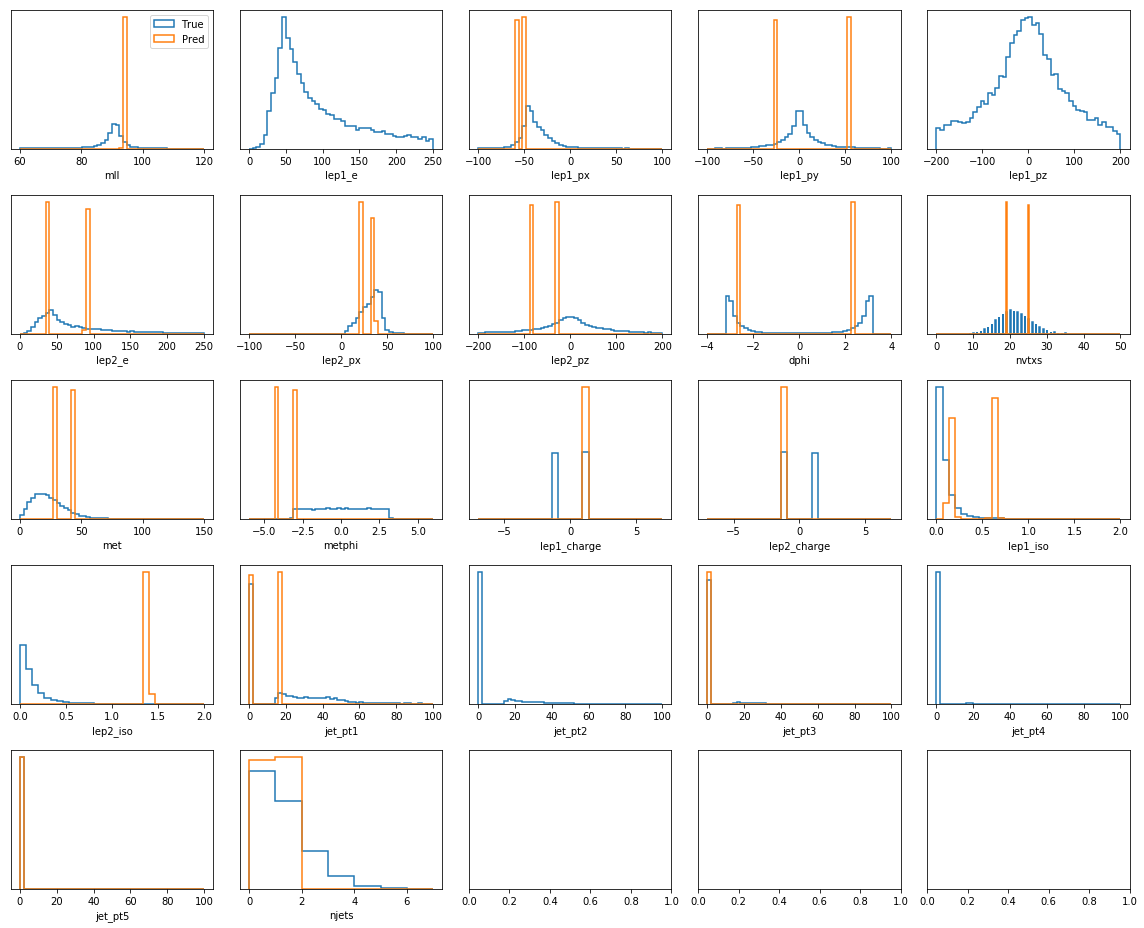

In [152]:
N = 20000
frac = 0.0001 # 2 events
# frac = 0.00005 # 1 event
# frac = 1.0
_, noise = gan.get_noise(N,max_true_samples_frac=frac)
preds = gan.generator.predict(noise,verbose=1)
make_plots(preds,gan.data[:N])

## Plot input-output events
For truth conditioned events, take the first 19 columns of the noise and the 19 output columns and subtract them. Then go column by column and plot histograms of the differences.

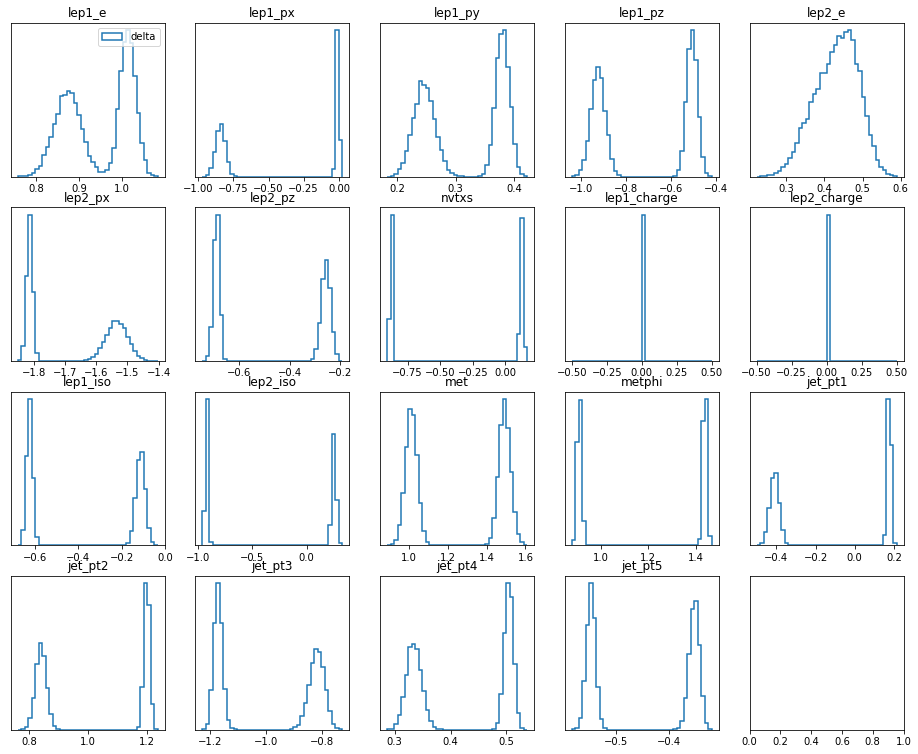

In [153]:
deltas = noise[:,:19]-preds[:,:19]
deltas = get_recview(deltas, dtype="<f8")

nrows, ncols = 4,5
fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
for axx in axs:
    for ax in axx:
        ax.get_yaxis().set_visible(False)
for ic,cname in enumerate(deltas.dtype.names):
    idx = ic // ncols, ic % ncols
    _ = axs[idx].hist(deltas[cname], bins=40, histtype="step", lw=1.5,label="delta")
    axs[idx].set_title("{}".format(cname))
    axs[idx].get_yaxis().set_visible(False)
_ = axs[0,0].legend()


## Recarray niceness
The real data (`gan.data`) is a recarray, so column indexing happens with `gan.data["lep1_px"]`.
The predictions from the generator are just normal matrices, so you have to do yucky things like `preds[:,7]`
and keep track of what that means. Use a helper function to get a `np.view` into the predictions so that
they columns can be accessed in the same way.

In [154]:
def Z_pT(data,haspy2=False):
    pxsum = data["lep1_px"]+data["lep2_px"]
    if haspy2: pysum = data["lep1_py"]+data["lep2_py"]
    else: pysum = data["lep1_py"]
    return np.sqrt(pxsum**2+pysum**2)

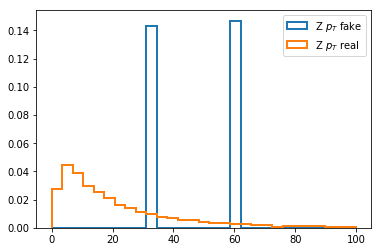

In [155]:
# plot Z_pT for predicted and real events
predsrec = get_recview(preds)
_ = plt.hist(Z_pT(predsrec,haspy2=False),label="Z $p_{T}$ fake",bins=np.linspace(0,100,30),histtype="step",density=True,lw=2)
_ = plt.hist(Z_pT(gan.data[:10000],haspy2=False), label="Z $p_{T}$ real",bins=np.linspace(0,100,30),histtype="step",density=True,lw=2)
_ = plt.legend()

real: 89.433395 11.899904
fake: 94.10176 0.18070766


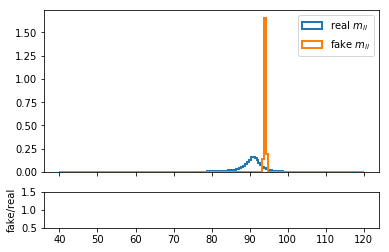

In [156]:
predmll = Minv(preds,ptetaphi=False,nopy2=True)
bins = np.linspace(40,120,160)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios':[9, 2]})
hreal = ax1.hist(gan.data["mll"],bins=bins, label="real $m_{ll}$",histtype="step",density=True,lw=2)
hfake = ax1.hist(predmll,bins=bins, label="fake $m_{ll}$",histtype="step",density=True,lw=2)
ratio = hfake[0]/hreal[0]
ax2.plot(bins[:-1],ratio,marker="o",markersize=3,linewidth=1.5,linestyle="")
ax2.set_ylim([0.5,1.5])
ax2.set_ylabel("fake/real")
_ = ax1.legend()
print "real:",gan.data["mll"].mean(), gan.data["mll"].std()
print "fake:",predmll.mean(), predmll.std()

In [157]:
data = np.load(gan.args["input_file"])

[1. 1. 5. ... 2. 2. 0.]
(array([996667,      0, 620953,      0, 260281,      0,  82624,      0,
        23021,   7656]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]))


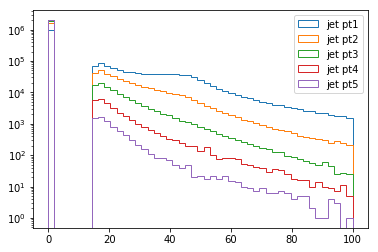

In [158]:
print 1.0*(data["genjet_pt1"]>10.)+ \
1.0*(data["genjet_pt2"]>10.)+ \
1.0*(data["genjet_pt3"]>10.)+ \
1.0*(data["genjet_pt4"]>10.)+ \
1.0*(data["genjet_pt5"]>10.)

print np.histogram(1.0*(data["jet_pt1"]>10.)+ \
1.0*(data["jet_pt2"]>10.)+ \
1.0*(data["jet_pt3"]>10.)+ \
1.0*(data["jet_pt4"]>10.)+ \
1.0*(data["jet_pt5"]>10.))

_ = plt.hist(data["jet_pt1"],histtype="step",bins=np.linspace(0,100,50), label="jet pt1")
_ = plt.hist(data["jet_pt2"],histtype="step",bins=np.linspace(0,100,50), label="jet pt2")
_ = plt.hist(data["jet_pt3"],histtype="step",bins=np.linspace(0,100,50), label="jet pt3")
_ = plt.hist(data["jet_pt4"],histtype="step",bins=np.linspace(0,100,50), label="jet pt4")
_ = plt.hist(data["jet_pt5"],histtype="step",bins=np.linspace(0,100,50), label="jet pt5")
plt.legend()
plt.yscale("log")

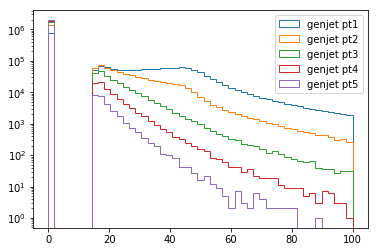

In [159]:
_ = plt.hist(data["genjet_pt1"],histtype="step",bins=np.linspace(0,100,50), label="genjet pt1")
_ = plt.hist(data["genjet_pt2"],histtype="step",bins=np.linspace(0,100,50), label="genjet pt2")
_ = plt.hist(data["genjet_pt3"],histtype="step",bins=np.linspace(0,100,50), label="genjet pt3")
_ = plt.hist(data["genjet_pt4"],histtype="step",bins=np.linspace(0,100,50), label="genjet pt4")
_ = plt.hist(data["genjet_pt5"],histtype="step",bins=np.linspace(0,100,50), label="genjet pt5")
plt.legend()
plt.yscale("log")

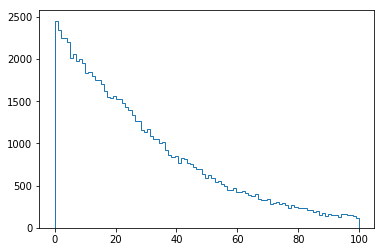

In [160]:
# _ = plt.hist(data["genlep1_px"],bins=np.linspace(-100,100,100), histtype="step")
# _ = plt.hist(data["genlep1_py"],bins=np.linspace(-100,100,100), histtype="step")
px1,py1 = data["genlep1_px"], data["genlep1_py"]
pt = (px1*px1+py1*py1)**0.5
# _ = plt.hist(pt,bins=np.linspace(0,100,100), histtype="step")
_ = plt.hist(px1[data["genmll"]>50],bins=np.linspace(0,100,100), histtype="step")
# _ = plt.hist2d(data["genlep1_px"],data["genlep1_py"],bins=[np.linspace(-100,100,100),np.linspace(-100,100,100)])

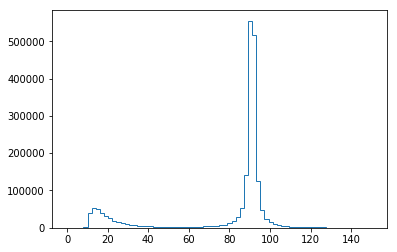

In [161]:
lepcoords = np.c_[
    data["lep1_e"],
    data["lep1_px"],
    data["lep1_py"],
    data["lep1_pz"],
    data["lep2_e"],
    data["lep2_px"],
        # no py2
    data["lep2_pz"],
]
m = Minv(lepcoords,nopy2=True)
_ = plt.hist(data["genmll"],bins=np.linspace(0,150,75),histtype="step")

In [162]:
print data["genmll"]

[90.68461 35.85359 81.39988 ... 89.09734 89.77282 73.71104]


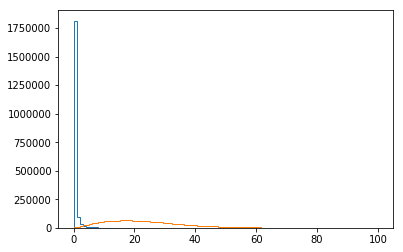

In [164]:

_ = plt.hist(data["genmet"],bins=np.linspace(0,100,100), histtype="step")
_ = plt.hist(data["met"],bins=np.linspace(0,100,100), histtype="step")